# Levins Metapopulation Model

The Levins model assumes a landscape consists of many discrete patches of habitat. We track the **fraction of occupied patches** ($p$) rather than population size. It balances local extinction with colonization of empty patches.

### 1. The Differential Equation
The rate of change in occupancy is Colonization minus Extinction:

$$\frac{dp}{dt} = c p (1 - p) - e p$$

Where:
* $p(t)$: Fraction of patches occupied ($0 \le p \le 1$).
* $c$: Colonization rate parameter.
* $e$: Local extinction rate parameter.
* $cp$: Propagules (colonizers) produced by occupied patches.
* $(1-p)$: Fraction of empty patches available to colonize.

### 2. Equilibrium and Stability
Setting $\frac{dp}{dt} = 0$:
$$p(c(1-p) - e) = 0$$

There are two fixed points:
1.  **$p^* = 0$**: The trivial solution (Metapopulation Extinction).
2.  **$p^* = 1 - \frac{e}{c}$**: The non-trivial stable equilibrium.

### 3. Condition for Persistence
For the metapopulation to survive ($p^* > 0$), we must have:
$$1 - \frac{e}{c} > 0 \implies c > e$$
This implies that the colonization rate must exceed the extinction rate.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def levins_model(p, t, c, e):
    """
    dp/dt = c*p*(1-p) - e*p
    """
    # Ensure p stays within [0, 1] physically, though ODE solver handles math
    return c * p * (1 - p) - e * p

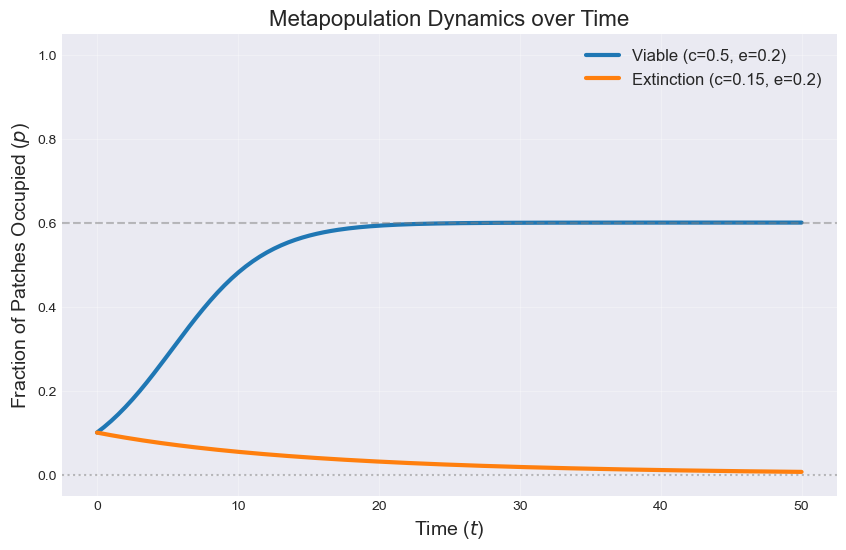

In [7]:
t = np.linspace(0, 50, 200)
e_rate = 0.2 # Constant extinction rate

scenarios = [
    {'c': 0.5, 'label': 'Viable (c=0.5, e=0.2)'},       # c > e
    {'c': 0.15, 'label': 'Extinction (c=0.15, e=0.2)'}  # c < e
]

initial_occupancy = 0.1 # Start with 10% of patches occupied

fig, ax = plt.subplots(figsize=(10, 6))

for sc in scenarios:
    c_val = sc['c']
    p_t = odeint(levins_model, initial_occupancy, t, args=(c_val, e_rate))
    
    # Calculate Theoretical Equilibrium
    if c_val > e_rate:
        equilibrium = 1 - (e_rate / c_val)
        style = '--'
    else:
        equilibrium = 0
        style = ':'
        
    ax.plot(t, p_t, linewidth=3, label=sc['label'])
    ax.axhline(equilibrium, color='gray', linestyle=style, alpha=0.5)

ax.set_title('Metapopulation Dynamics over Time', fontsize=16)
ax.set_xlabel('Time ($t$)', fontsize=14)
ax.set_ylabel('Fraction of Patches Occupied ($p$)', fontsize=14)
ax.set_ylim(-0.05, 1.05)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.show()

### Phase Diagram

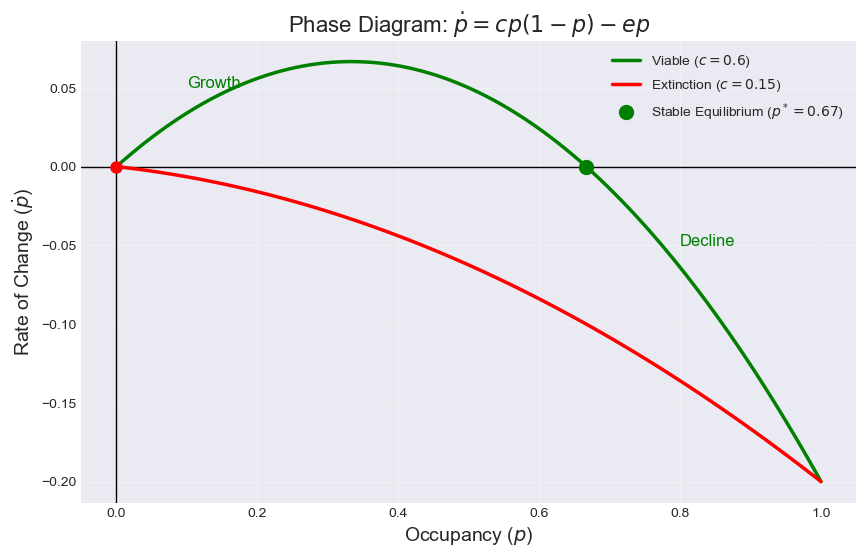

In [8]:
p_phase = np.linspace(0, 1, 100)
e_fixed = 0.2
c_viable = 0.6
c_extinct = 0.15

dp_viable = levins_model(p_phase, 0, c_viable, e_fixed)
dp_extinct = levins_model(p_phase, 0, c_extinct, e_fixed)


fig, ax = plt.subplots(figsize=(10, 6))

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.plot(p_phase, dp_viable, 'g-', linewidth=2.5, label=f'Viable ($c={c_viable}$)')
ax.plot(p_phase, dp_extinct, 'r-', linewidth=2.5, label=f'Extinction ($c={c_extinct}$)')

p_star = 1 - e_fixed/c_viable
ax.plot(p_star, 0, 'go', markersize=10, label=f'Stable Equilibrium ($p^*={p_star:.2f}$)')
ax.plot(0, 0, 'ro', markersize=8) # 0 is unstable for green, stable for red

ax.text(0.1, 0.05, 'Growth', color='green', fontsize=12)
ax.text(0.8, -0.05, 'Decline', color='green', fontsize=12)

ax.set_title('Phase Diagram: $\dot{p} = cp(1-p) - ep$', fontsize=16)
ax.set_xlabel('Occupancy ($p$)', fontsize=14)
ax.set_ylabel('Rate of Change ($\dot{p}$)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

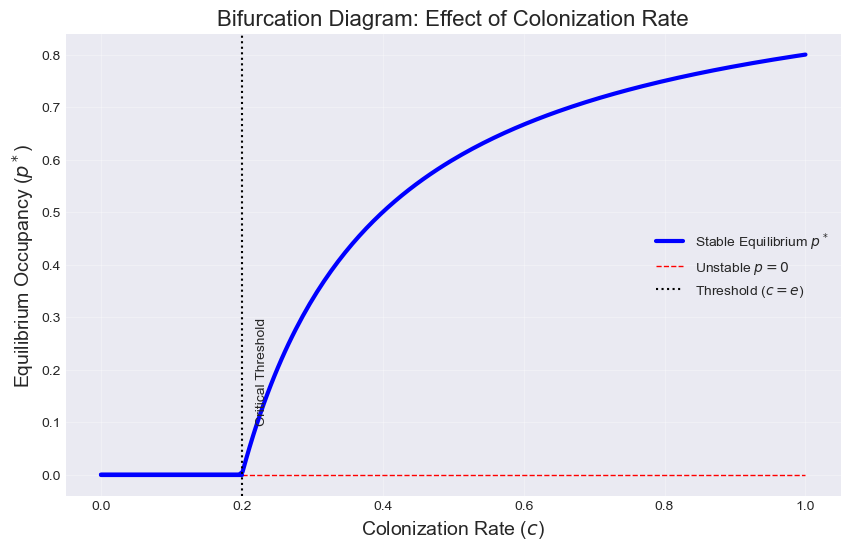

In [9]:
c_values = np.linspace(0, 1.0, 200)
e_val = 0.2

equilibria = []
stability = []  # To track stable vs unstable branches for p=0

for c in c_values:
    if c > e_val:
        p_star = 1 - (e_val / c)
        equilibria.append(p_star)
    else:
        equilibria.append(0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(c_values, equilibria, 'b-', linewidth=3, label='Stable Equilibrium $p^*$')

# Plot the unstable p=0 branch (dashed) where c > e
c_unstable = np.linspace(e_val, 1.0, 100)
ax.plot(c_unstable, np.zeros_like(c_unstable), 'r--', linewidth=1, label='Unstable $p=0$')

# Plot the stable p=0 branch (solid) where c < e
c_stable_zero = np.linspace(0, e_val, 50)
ax.plot(c_stable_zero, np.zeros_like(c_stable_zero), 'b-', linewidth=3)

# Add Threshold Line
ax.axvline(e_val, color='k', linestyle=':', label='Threshold ($c=e$)')
ax.text(e_val + 0.02, 0.1, 'Critical Threshold', rotation=90)

ax.set_title('Bifurcation Diagram: Effect of Colonization Rate', fontsize=16)
ax.set_xlabel('Colonization Rate ($c$)', fontsize=14)
ax.set_ylabel('Equilibrium Occupancy ($p^*$)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

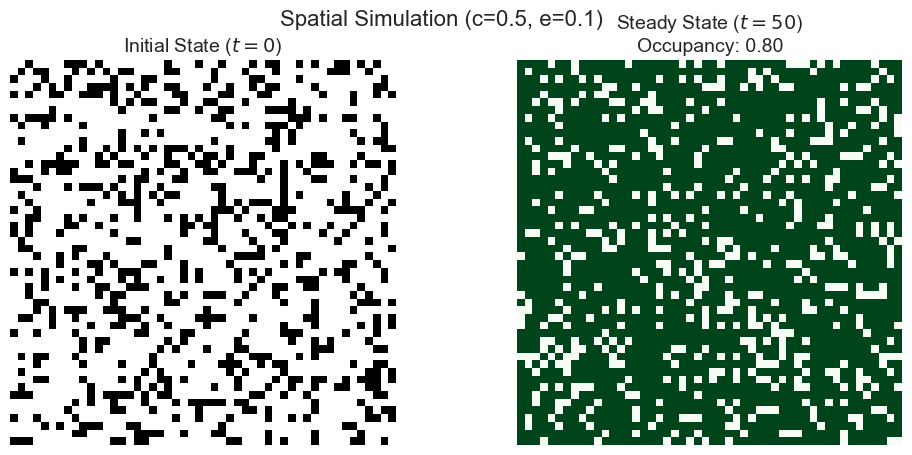

In [10]:
def update_grid(grid, c, e):
    """
    Update rule for Levins Cellular Automaton
    """
    N = grid.shape[0]
    new_grid = grid.copy()
    
    # Calculate global occupancy (Mean Field approximation)
    p = np.mean(grid)
    
    for i in range(N):
        for j in range(N):
            if grid[i, j] == 1:
                # Extinction Chance
                if np.random.random() < e:
                    new_grid[i, j] = 0
            else:
                # Colonization Chance (depends on global p)
                # Prob of being colonized = c * p
                if np.random.random() < (c * p):
                    new_grid[i, j] = 1
    return new_grid

# --- Simulation ---
grid_size = 50
grid = np.random.choice([0, 1], size=(grid_size, grid_size), p=[0.8, 0.2])
c_sim = 0.5
e_sim = 0.1

# Run for 100 steps
history = []
for _ in range(50):
    grid = update_grid(grid, c_sim, e_sim)
    history.append(grid)

# --- Plotting Snapshot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial State
ax1.imshow(history[0], cmap='Greys', interpolation='nearest')
ax1.set_title('Initial State ($t=0$)', fontsize=14)
ax1.axis('off')

# Final State
ax2.imshow(history[-1], cmap='Greens', interpolation='nearest')
ax2.set_title(f'Steady State ($t=50$)\nOccupancy: {np.mean(history[-1]):.2f}', fontsize=14)
ax2.axis('off')

plt.suptitle(f'Spatial Simulation (c={c_sim}, e={e_sim})', fontsize=16)
plt.show()